# Computing the Euler Characteristic Transform (ECT)

Once we have the cubical complex of an object and set of unit-length directions in the adequate dimension (either 2D or 3D for practical purposes), we can ask for the object's ECT as proposed by [Turner et al (2014)](https://doi.org/10.1093/imaiai/iau011). 

The computation of the ECT depends on being able to efficiently different iterations of the Euler Characteristic Curve (ECC). Here, we followed a binsort strategy as discussed in [Richardson and Werman (2014)](https://doi.org/10.1016/j.patrec.2014.07.001). This strategy allows us to compute an ECC is $O(N+T)$ time, with $N$ the number of vertices in our complex and $T$ the number of thresholds. Usually, $T$ is quite small compared to $N$, so we can ignore it. Thus, we can compute an ECT in $O(ND)$ time, with $D$ the number of directions.

<img src=https://www.egr.msu.edu/~amezqui3/barley/figs/ect_filter_49.png width="700">

In [1]:
import tifffile as tf
import numpy as np
import os
import argparse
import glob
import math
import importlib
import time
import itertools
import pandas as pd
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage
import scipy.special as special
from matplotlib import cm

import brewing_utils as brew

## Load a 3D scan and complexify it

In [2]:
seed = '../data/tiffs/seed_8_0_p7_d4_t120_o7_e1_g3.tif'
img = tf.imread(seed)
img[img > 0] = 1

tic = time.perf_counter()
Cells = brew.complexify(img)
toc = time.perf_counter()

cellnames = ['vertices', 'edges', 'squares', 'cubes', '4hypercubes']

print("Complexify in {:.4f} seconds.\n\nCubical complex made of:".format(toc-tic))
for i in range(len(Cells)):
    print('{}\t{}'.format(len(Cells[i]), cellnames[i]))

Complexify in 2.1028 seconds.

Cubical complex made of:
53631	vertices
154741	edges
148746	squares
47635	cubes


## Align the seed scan according to their principal components

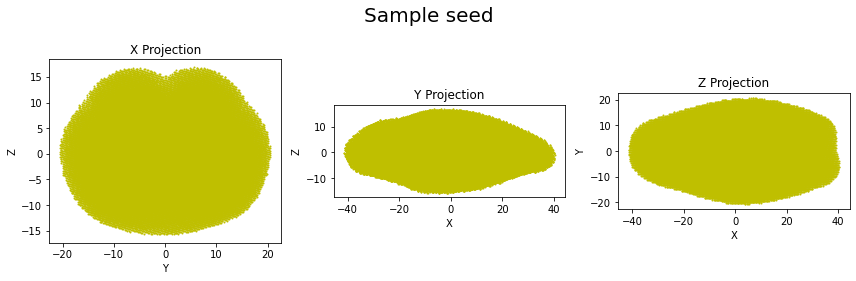

In [3]:
max_vox = brew.find_tip(Cells[0], 2,1,0)
seed,_, _, _,_ = brew.rotateSVD(Cells[0], max_vox)

brew.plot_3Dprojections(seed, 'Sample seed')

## Define a set of directions on the sphere

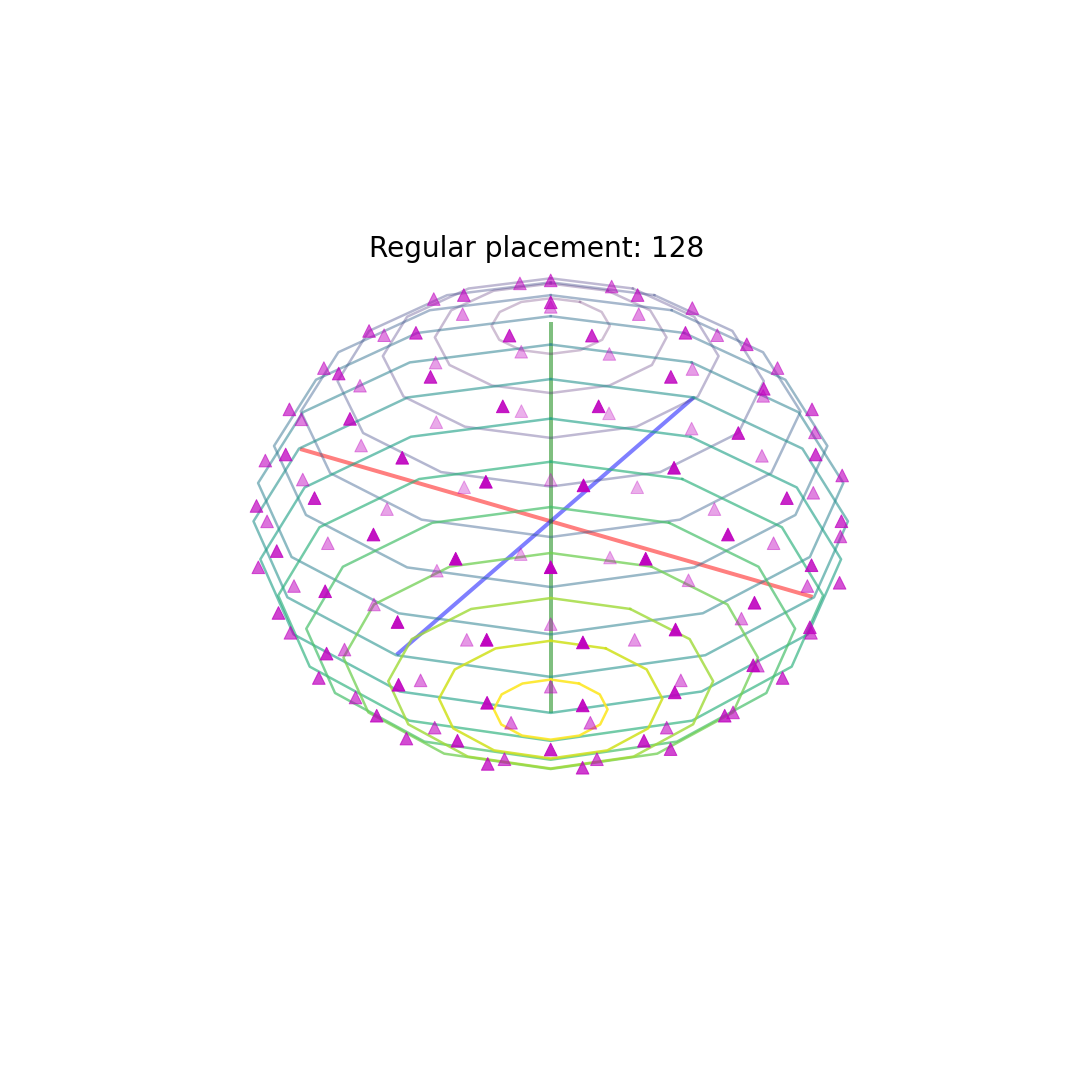

In [4]:
directions = brew.regular_directions(128)
title = 'Regular placement: {}'.format(len(directions))
filename = 'uniform_directions_{}'.format(len(directions))
brew.plot_pole_directions(directions, title)

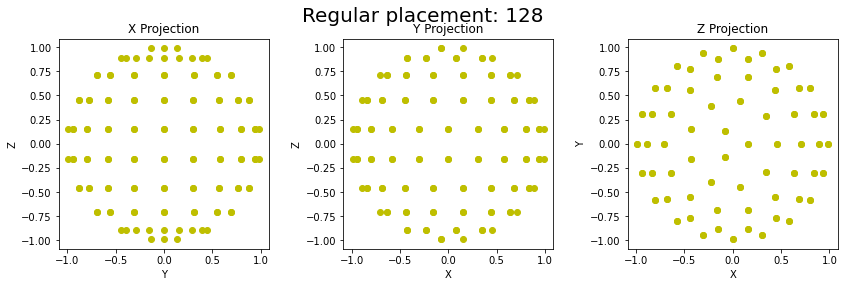

In [5]:
brew.plot_3Dprojections(directions, title, markersize=12)

## One Direction: compute the Euler Characteristic Curve (ECC)

- Fix a direction $v$ (we'll use `(0,0,1)`, the vertical direction.)
- Fix a number of thresholds `T`, that is, number of sublevel sets to consider
- Compute the height of every vertex $x$ with respect to our set direction, which is simply the standard inner product $\langle x,v\rangle$ (also known as dot product.)

In [6]:
T = 32
i = 0
direction = directions[i, :]
print(direction)
heights = np.sum(seed*direction, axis=1)
heights

[0.15643447 0.         0.98768834]


array([-10.01013537, -10.58290583, -11.15567629, ...,   8.7512732 ,
         8.17850274,   7.60573228])

### Binsort

- All the possible height values lie in an interval $[h_{\rm min},h_{\rm max}]$ which depends on our height direction $v$.
- Split the $[h_{\rm min},h_{\rm max}]$ interval into $T$ equispaced thresholds $t_0 = h_{\rm min} < t_1 < \ldots < t_{T-1} < t_T = h_{\rm max}$
- We're **not** interested in the exact sorting of the height values but how many height values are within each interval $(t_i, t_{i+1}]$
- This binsort runs in linear time with respect to number of vertices instead of $N\log N$ time.

In [7]:
minh = np.min(heights)
maxh = np.max(heights)
print('h_min = {:.2f},\th_max={:.2f}'.format(minh, maxh))
buckets = [None for i in range(len(Cells))]
buckets[0],bins = np.histogram(heights, bins=T, range=(minh, maxh))
buckets[0]

h_min = -16.84,	h_max=16.76


array([  88,  350,  717, 1229, 1312, 1187, 1672, 2004, 2156, 2136, 1833,
       1982, 2543, 2653, 2635, 2168, 2140, 2592, 2698, 2635, 2216, 1901,
       2067, 2218, 2008, 1702, 1168,  987, 1107,  830,  524,  173])

- Observe that bin-sorting the height values within the $[h_{\min}, h_{\max}]$ interval normalizes the object.
- Thus, the ECT ignores the specific size of the measured object
- We can tamper with the normalization by increasing the `range` when computing `np.histogram`

In [8]:
foo,bar = np.histogram(heights, bins=T, range=(-20,20))
foo

array([   0,    0,   42,  396,  717, 1229, 1508, 1760, 2347, 2568, 2441,
       2408, 2504, 2615, 3121, 3237, 3130, 2727, 2669, 2605, 2773, 2843,
       2517, 1889, 1600, 1351, 1149, 1011,  430,   44,    0,    0])

- For the higher-order cubical cells, their height is defined as the max height out of all their vertices.
- For example, when looking at squares, we can ask for the heights associated to different vertices and pick the largest one.
- Do a binsort as in the vertex case.

In [9]:
heights[Cells[2]]

array([[-10.01013537, -10.58290583,  -9.43083353, -10.00360399],
       [-10.01013537, -10.58290583,  -9.43018418, -10.00295464],
       [-10.01013537,  -9.43083353,  -9.43018418,  -8.85088234],
       ...,
       [  7.01989907,   6.44712861,   7.5992009 ,   7.02643044],
       [  8.17197137,   7.5992009 ,   8.7512732 ,   8.17850274],
       [  7.5992009 ,   7.02643044,   8.17850274,   7.60573228]])

In [10]:
np.max(heights[Cells[2]], axis=1)

array([-9.43083353, -9.43018418, -8.85088234, ...,  7.5992009 ,
        8.7512732 ,  8.17850274])

In [11]:
for i in range(1,len(buckets)):
    buckets[i],_ = np.histogram(np.max(heights[Cells[i]], axis=1), bins=T, range=(minh, maxh))

- Finally, we do an alternate sum of cubical simplices for each threshold interval
- To compute efficiently the Euler characteristic curve, we do a cumulative sum that yields the EC values for all the sublevel sets.

In [12]:
ecc = np.zeros_like(buckets[0])
for i in range(len(buckets)):
    ecc = np.add(ecc, ((-1)**i)*buckets[i])

np.cumsum(ecc)

array([ 43,  12,  18, -69,  -3,   0,   0,   3,   2,  -2,   0,  -2,   7,
         6,   3,  -5,  -1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1])

## The whole discussion above is neatly executed by the `ECC` function

`ECC` takes as parameters:
- `verts`: N-dimensional array: vertices. 
- `cells`: list: structure of higher dimensional cells. Computed by `complexify`
- `filtration`: 1-dimensional array: filtration values. Array must be the same length as `verts`
- `T`: int: number of thresholds (_default `T=32`_)
- `bbox`: tuple: bounding box corresponding to $(h_\min, h_\max)$ histogram bounds. If `None`, the bounds correspond to the extreme values of `filtration`. (_default `None`_)

Returns:
- `ecc`: 1-dimensional array: values of the Euler characteristic as we filter the image


## Toggling the `T` parameter

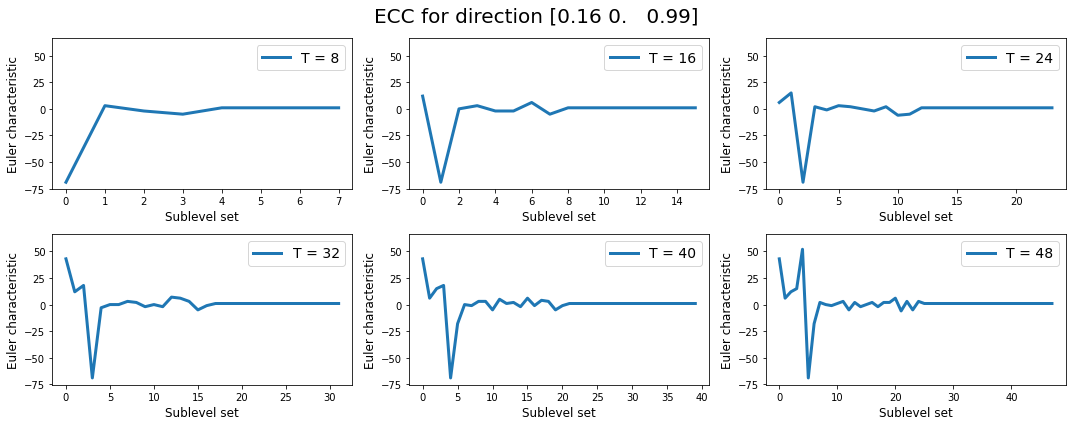

In [14]:
importlib.reload(brew)
T = [8,16,24,32,40,48]
i = 0
direction = directions[i,:]
heights = np.sum(seed*direction, axis=1)

fig, ax = plt.subplots(2,3, figsize=(15,6))
fig.suptitle('ECC for direction {}'.format(np.around(direction,2)), fontsize=20)

for j in range(2):
    for k in range(3):
        ax[j,k].plot(0,60, c='white')
        ax[j,k].set_ylabel('Euler characteristic', fontsize=12)
        ax[j,k].set_xlabel('Sublevel set', fontsize=12)
        ax[j,k].plot(brew.ECC(seed, Cells, heights, T[3*j+k]),lw=3, label = 'T = {}'.format(T[3*j+k]))
        ax[j,k].legend(fontsize=14)
        
fig.tight_layout()
#plt.savefig('../data/ECC_normalized_d{}.jpg'.format(directions[i,:]), 
#                dpi=150, format='jpg', pil_kwargs={'optimize':True});

- Tamper with the $[h_{\min}, h_{\max}]$ to account for size

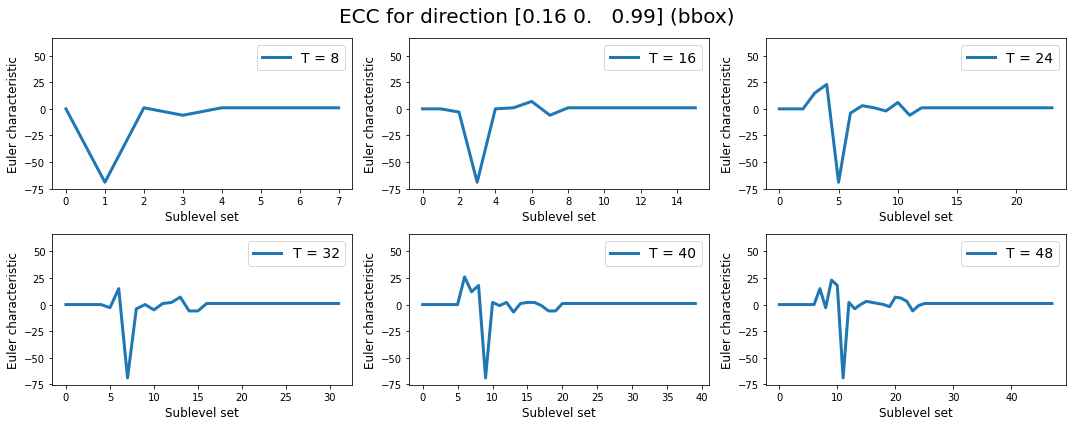

In [16]:
importlib.reload(brew)
T = [8,16,24,32,40,48]

fig, ax = plt.subplots(2,3, figsize=(15,6))
fig.suptitle('ECC for direction {} (bbox)'.format(np.around(direction,2)), fontsize=20)

for j in range(2):
    for k in range(3):
        ax[j,k].plot(0,60, c='white')
        ax[j,k].set_ylabel('Euler characteristic', fontsize=12)
        ax[j,k].set_xlabel('Sublevel set', fontsize=12)
        ax[j,k].plot(brew.ECC(seed, Cells, heights, T[3*j+k], bbox=(-25,25)),
                     lw=3, label = 'T = {}'.format(T[3*j+k]))
        ax[j,k].legend(fontsize=14)
        
fig.tight_layout()
plt.savefig('../data/ECC_unnormalized_d{}.jpg'.format(directions[i,:]), 
                dpi=150, format='jpg', pil_kwargs={'optimize':True});

## Compute the whole ECT

- To compute the ECT, we simply concatenate a number of ECCs
- Observe that computing each ECC is quickly computed on average
- Whenever computing the ECT, the most expensive step is the complexification of the scan.
- Once an image/scan is complexified, we should make the most out of it

In [18]:
T =32
ect = np.zeros(T*directions.shape[0], dtype=int)

tic = time.perf_counter()
for i in range(directions.shape[0]):
    heights = np.sum(seed*directions[i,:], axis=1)
    ect[i*T : (i+1)*T] = brew.ECC(seed, Cells, heights, T)
toc = time.perf_counter()

print("ECT with {} directions in {:.4f} seconds.\n{:.4f}s per direction".format(len(directions), toc-tic, (toc-tic)/len(directions)))

ECT with 128 directions in 1.7087 seconds.
0.0133s per direction


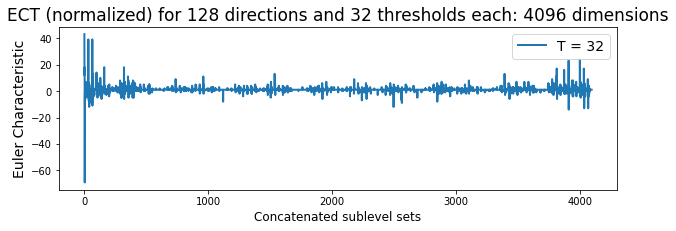

In [19]:
plt.subplots(figsize = (10,3))

plt.plot(ect, lw=2, label = 'T = {}'.format(T))
plt.title('ECT (normalized) for {} directions and {} thresholds each: {} dimensions'. format(len(directions), T, len(directions)*T),
          fontsize=17)
plt.ylabel('Euler Characteristic', fontsize=14)
plt.xlabel('Concatenated sublevel sets', fontsize=12)
plt.legend(fontsize=14);

## The above is implemented with the `ECT` function

The `ECT` function assumes that the filters are directional. Parameters:

- `verts`: N-dimensional array: vertices. 
- `cells`: list: structure of higher dimensional cells. Computed by `complexify`
- `directions`: NxD array: Array of directions that define the directional filters to consider.
- `T`: int: number of thresholds for every direction (_default `T=32`_)
- `bbox`: tuple: bounding box corresponding to $(h_\min, h_\max)$ histogram bounds. If `None`, the bounds correspond to the extreme values of `filtration`. (_default `None`_)

Returns:
- `ect`: 1-dimensional array: values of the Euler characteristic as we filter the image across all directional filters.

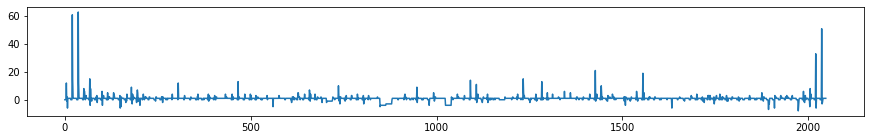

In [21]:
ect = brew.ECT(seed, Cells, directions, T=16, bbox=(-40,40))
plt.figure(figsize=(15,2))
plt.plot(ect);